# Coronavirus in South Korea

This Analysis will be separated in to two parts, namely Capstone 1 and Capstone 2. In Capstone 1, I will inspect and wrangle the data to provide clear analysis of the affect of the virus on patients and seek to learn about the rates of deceased, along with which categories of patients are most likely to die from infection.

The accumulated confirmation count in South korea is increasing exponentially after 22nd of feb. Till the date 15th of feb 2020 it was negligible. There are many reason for infection but most cases have similar reasons that they have visited to wuhan. South Korea has raised its coronavirus alert to the "highest level" as confirmed case numbers keep rising.South Korea has seen the largest number of confirmed cases after China. More than 4,800 people have confirmed the infection of coronavirus.  As the data set says the western part of the country is more affected. Daegu and Gyeongsangbukdo region of South Korea are highly infected by the coronavirus

## Capstone 1

My hypothesis is that the greatest number of casualties from infected people will be people over the age of 70. 

The data shows this hypothesis is incorrect, and in fact the casualties tend to lie in the 48-98 year range, and are more likely to be male than female.

##  Capstone 2

I will attempt to make predictions about the spread of the virus using fbprophet.

**Libraries**

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


Using TensorFlow backend.
C:\Users\Student\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Student\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Student\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Student\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understo

**Reading Data**

In [2]:
comp = pd.read_excel('COVID-19-3.27-top30-500.xlsx')

In [3]:
df_patient = pd.read_csv("patient.csv")
df_route = pd.read_csv("route.csv")

**Looking into patient data**

In [4]:
df_patient.head()

patient_id     sex  birth_year country               region  disease group  \
0           1  female      1984.0   China  filtered at airport      NaN   NaN   
1           2    male      1964.0   Korea  filtered at airport      NaN   NaN   
2           3    male      1966.0   Korea         capital area      NaN   NaN   
3           4    male      1964.0   Korea         capital area      NaN   NaN   
4           5    male      1987.0   Korea         capital area      NaN   NaN   

  infection_reason  infection_order  infected_by  contact_number  \
0   visit to Wuhan              1.0          NaN            45.0   
1   visit to Wuhan              1.0          NaN            75.0   
2   visit to Wuhan              1.0          NaN            16.0   
3   visit to Wuhan              1.0          NaN            95.0   
4   visit to Wuhan              1.0          NaN            31.0   

  confirmed_date released_date deceased_date     state  
0     2020-01-20    2020-02-06           NaN  released  
1     2020-01-24    2020-02-05           NaN  released  
2     2020-01-26    2020-02-12           NaN  released  
3     2020-01-27    2020-02-09           NaN  released  
4     2020-01-30    2020-03-02           NaN  released

1.  **id** the ID of the patient (n-th confirmed patient)
2.  **sex** the sex of the patient
3.  **birth_year** the birth year of the patient
4.  **country** the country of the patient
5.  **region** the region of the patient
6.  **group** the collective infection
7.  **infection_reason** the reason of infection
8.  **infection_order** the order of infection
9.  **infected_by** the ID of who has infected the patient
10. **contact_number** the number of contacts with people
11. **confirmed_date** the date of confirmation
12. **released_date** the date of discharge
13. **deceased_date** the date of decease
14. **state** isolated / released / deceased

In [5]:
df_patient.isna().sum()


patient_id             0
sex                 7190
birth_year          7203
country                0
region              7432
disease             7841
group               7783
infection_reason    7715
infection_order     7833
infected_by         7799
contact_number      7816
confirmed_date         0
released_date       7813
deceased_date       7833
state                  0
dtype: int64

In [6]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda val: val if val > 0 else np.nan)

In [7]:
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby(df_patient.confirmed_date).patient_id.count()
accumulated_count = daily_count.cumsum()




In [8]:
df_patient['age'] = 2020 - df_patient['birth_year'] 

In [9]:
import math
def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"


df_patient["age_range"] = df_patient["age"].apply(group_age)

In [10]:
df_patient.head()

patient_id     sex  birth_year country               region  disease group  \
0           1  female      1984.0   China  filtered at airport      NaN   NaN   
1           2    male      1964.0   Korea  filtered at airport      NaN   NaN   
2           3    male      1966.0   Korea         capital area      NaN   NaN   
3           4    male      1964.0   Korea         capital area      NaN   NaN   
4           5    male      1987.0   Korea         capital area      NaN   NaN   

  infection_reason  infection_order  infected_by  contact_number  \
0   visit to Wuhan              1.0          NaN            45.0   
1   visit to Wuhan              1.0          NaN            75.0   
2   visit to Wuhan              1.0          NaN            16.0   
3   visit to Wuhan              1.0          NaN            95.0   
4   visit to Wuhan              1.0          NaN            31.0   

  confirmed_date released_date deceased_date     state   age age_range  
0     2020-01-20    2020-02-06           NaN  released  36.0     30-39  
1     2020-01-24    2020-02-05           NaN  released  56.0     50-59  
2     2020-01-26    2020-02-12           NaN  released  54.0     50-59  
3     2020-01-27    2020-02-09           NaN  released  56.0     50-59  
4     2020-01-30    2020-03-02           NaN  released  33.0     30-39

In [11]:
patient=df_patient

**Preprocessing**

In [12]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [13]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]

patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]


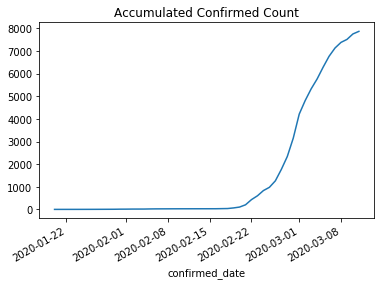

In [14]:
accumulated_count.plot()
plt.title('Accumulated Confirmed Count');

**Time series Analysis**

In [15]:
time = pd.read_csv("covid_19_data.csv")

In [16]:
time = time[time['Country/Region']=='South Korea']

In [17]:
time = time.tail(14)

In [18]:
time.head()

SNo ObservationDate Province/State Country/Region          Last Update  \
5635  5636      03/15/2020            NaN    South Korea  2020-03-15T18:20:18   
5894  5895      03/16/2020            NaN    South Korea  2020-03-16T14:38:45   
6167  6168      03/17/2020            NaN    South Korea  2020-03-17T10:33:03   
6444  6445      03/18/2020            NaN    South Korea  2020-03-18T02:53:03   
6728  6729      03/19/2020            NaN    South Korea  2020-03-19T02:13:17   

      Confirmed  Deaths  Recovered  
5635     8162.0    75.0      510.0  
5894     8236.0    75.0     1137.0  
6167     8320.0    81.0     1407.0  
6444     8413.0    84.0     1540.0  
6728     8565.0    91.0     1540.0

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


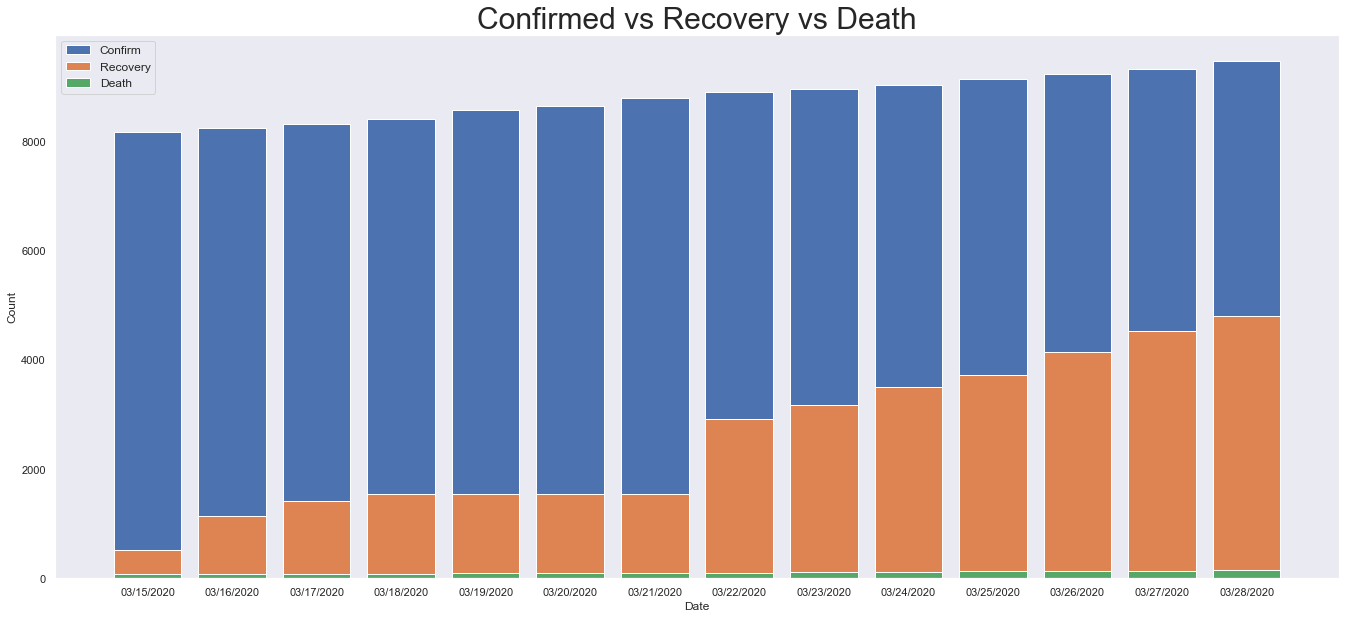

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

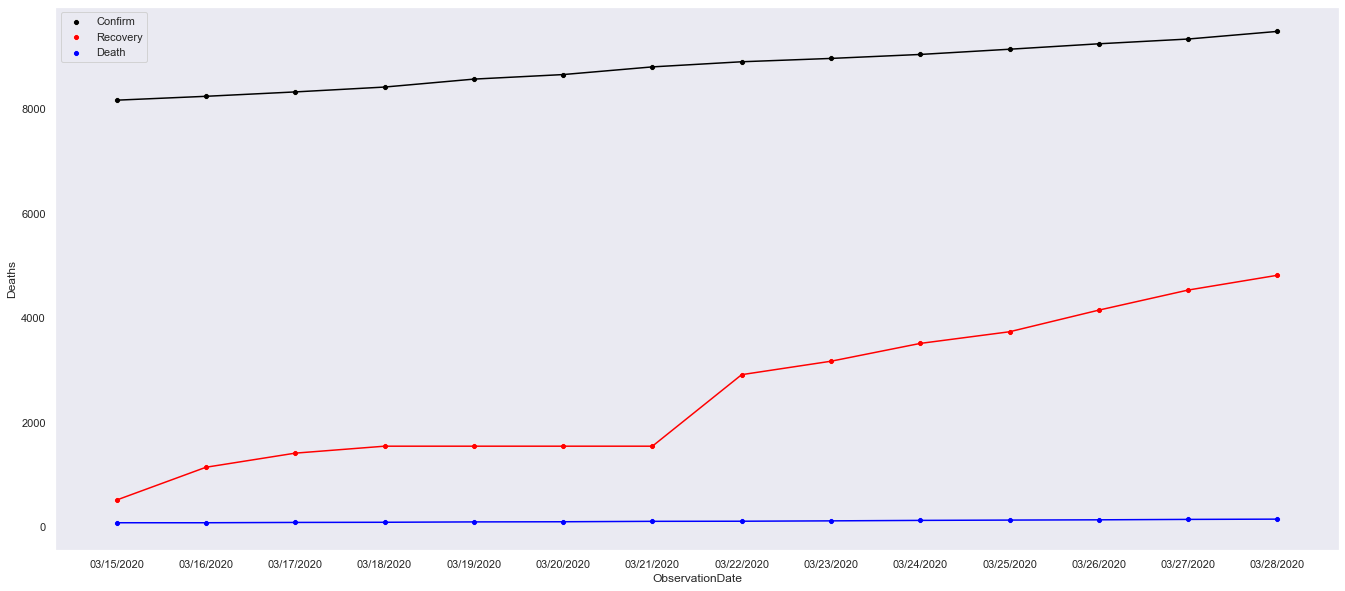

In [100]:
plt.figure(figsize=(23,10))
plt.bar(time.ObservationDate, time.Confirmed,label="Confirm")
plt.bar(time.ObservationDate, time.Recovered,label="Recovery")
plt.bar(time.ObservationDate, time.Deaths,label="Death")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.title('Confirmed vs Recovery vs Death',fontsize=30)
plt.show()

f, ax = plt.subplots(figsize=(23,10))
ax=sns.scatterplot(x="ObservationDate", y="Confirmed", data=time,
             color="black",label = "Confirm")
ax=sns.scatterplot(x="ObservationDate", y="Recovered", data=time,
             color="red",label = "Recovery")
ax=sns.scatterplot(x="ObservationDate", y="Deaths", data=time,
             color="blue",label = "Death")
plt.plot(time.ObservationDate,time.Confirmed,zorder=1,color="black")
plt.plot(time.ObservationDate,time.Recovered,zorder=1,color="red")
plt.plot(time.ObservationDate,time.Deaths,zorder=1,color="blue")

**Current State of Patient**

In [20]:
infected_patient = patient.shape[0]
rp = patient.loc[patient["state"] == "released"].shape[0]
dp = patient.loc[patient["state"] == "deceased"].shape[0]
ip = patient.loc[patient["state"]== "isolated"].shape[0]
rp=rp/patient.shape[0]
dp=dp/patient.shape[0]
ip=ip/patient.shape[0]
print("The percentage of recovery is "+ str(rp*100) )
print("The percentage of deceased is "+ str(dp*100) )
print("The percentage of isolated is "+ str(ip*100) )


The percentage of recovery is 0.7116533231668573
The percentage of deceased is 0.4574914220358368
The percentage of isolated is 98.8308552547973


In [21]:
states = pd.DataFrame(patient["state"].value_counts())
states["status"] = states.index
states.rename(columns={"state": "count"}, inplace=True)

fig = px.pie(states,
             values="count",
             names="status",
             title="Current state of patients",
             template="seaborn")
fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
fig.show()

**People who released**

In [22]:
released = df_patient[df_patient.state == 'released']
released.head()

patient_id     sex  birth_year country               region  disease group  \
0           1  female      1984.0   China  filtered at airport      NaN   NaN   
1           2    male      1964.0   Korea  filtered at airport      NaN   NaN   
2           3    male      1966.0   Korea         capital area      NaN   NaN   
3           4    male      1964.0   Korea         capital area      NaN   NaN   
4           5    male      1987.0   Korea         capital area      NaN   NaN   

  infection_reason  infection_order  infected_by  ...  released_date  \
0   visit to Wuhan              1.0          NaN  ...     2020-02-06   
1   visit to Wuhan              1.0          NaN  ...     2020-02-05   
2   visit to Wuhan              1.0          NaN  ...     2020-02-12   
3   visit to Wuhan              1.0          NaN  ...     2020-02-09   
4   visit to Wuhan              1.0          NaN  ...     2020-03-02   

  deceased_date     state   age age_range  time_to_release_since_confirmed  \
0           NaT  released  36.0     30-39                          17 days   
1           NaT  released  56.0     50-59                          12 days   
2           NaT  released  54.0     50-59                          17 days   
3           NaT  released  56.0     50-59                          13 days   
4           NaT  released  33.0     30-39                          32 days   

  time_to_death_since_confirmed duration_since_confirmed duration_days  \
0                           NaT                  17 days          17.0   
1                           NaT                  12 days          12.0   
2                           NaT                  17 days          17.0   
3                           NaT                  13 days          13.0   
4                           NaT                  32 days          32.0   

   state_by_gender  
0  released_female  
1    released_male  
2    released_male  
3    released_male  
4    released_male  

[5 rows x 22 columns]

**People who are in isolated state**

In [23]:
isolated_state = df_patient[df_patient.state == 'isolated']
isolated_state.head()

patient_id     sex  birth_year country        region  disease  \
25          26    male      1968.0   Korea  capital area      NaN   
26          27  female      1982.0   China  capital area      NaN   
28          29    male      1938.0   Korea  capital area      NaN   
29          30  female      1952.0   Korea  capital area      NaN   
30          31  female      1959.0   Korea         Daegu      NaN   

                 group      infection_reason  infection_order  infected_by  \
25                 NaN  contact with patient              1.0         27.0   
26                 NaN        visit to China              1.0          NaN   
28                 NaN  contact with patient              4.0         83.0   
29                 NaN  contact with patient              5.0         29.0   
30  Shincheonji Church                   NaN              NaN          NaN   

    ...  released_date deceased_date     state   age age_range  \
25  ...            NaT           NaT  isolated  52.0     50-59   
26  ...            NaT           NaT  isolated  38.0     30-39   
28  ...            NaT           NaT  isolated  82.0     80-89   
29  ...            NaT           NaT  isolated  68.0     60-69   
30  ...            NaT           NaT  isolated  61.0     60-69   

    time_to_release_since_confirmed time_to_death_since_confirmed  \
25                              NaT                           NaT   
26                              NaT                           NaT   
28                              NaT                           NaT   
29                              NaT                           NaT   
30                              NaT                           NaT   

   duration_since_confirmed duration_days  state_by_gender  
25                      NaT           NaN    isolated_male  
26                      NaT           NaN  isolated_female  
28                      NaT           NaN    isolated_male  
29                      NaT           NaN  isolated_female  
30                      NaT           NaN  isolated_female  

[5 rows x 22 columns]

**Patient who died**

In [24]:
dead = df_patient[df_patient.state == 'deceased']
dead.head()

patient_id     sex  birth_year country            region  disease  \
37           38  female      1963.0   Korea             Daegu      1.0   
53           54    male      1963.0   Korea  Gyeongsangbuk-do      1.0   
54           55    male      1961.0   Korea  Gyeongsangbuk-do      1.0   
103         104    male      1957.0   Korea  Gyeongsangbuk-do      1.0   
106         107    male      1953.0   Korea  Gyeongsangbuk-do      1.0   

                        group infection_reason  infection_order  infected_by  \
37                        NaN              NaN              NaN          NaN   
53   Cheongdo Daenam Hospital              NaN              NaN          NaN   
54   Cheongdo Daenam Hospital              NaN              NaN          NaN   
103  Cheongdo Daenam Hospital              NaN              NaN          NaN   
106  Cheongdo Daenam Hospital              NaN              NaN          NaN   

     ...  released_date deceased_date     state   age age_range  \
37   ...            NaT    2020-02-23  deceased  57.0     50-59   
53   ...            NaT    2020-02-23  deceased  57.0     50-59   
54   ...            NaT    2020-02-23  deceased  59.0     50-59   
103  ...            NaT    2020-02-19  deceased  63.0     60-69   
106  ...            NaT    2020-02-24  deceased  67.0     60-69   

     time_to_release_since_confirmed time_to_death_since_confirmed  \
37                               NaT                        5 days   
53                               NaT                        4 days   
54                               NaT                        4 days   
103                              NaT                       -1 days   
106                              NaT                        3 days   

    duration_since_confirmed duration_days  state_by_gender  
37                    5 days           5.0  deceased_female  
53                    4 days           4.0    deceased_male  
54                    4 days           4.0    deceased_male  
103                  -1 days          -1.0    deceased_male  
106                   3 days           3.0    deceased_male  

[5 rows x 22 columns]

**Age distribution of the released**

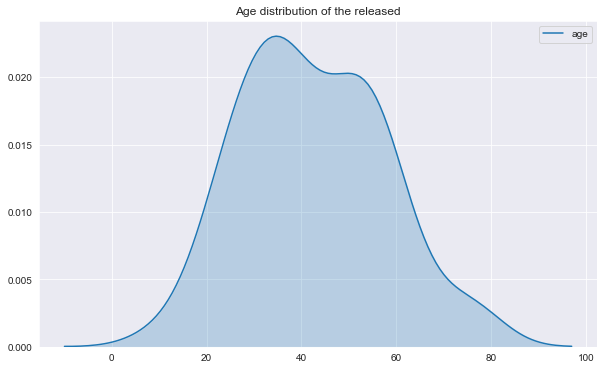

In [25]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the released")
sns.kdeplot(data=released['age'], shade=True)

**Age distribution of isolated person**

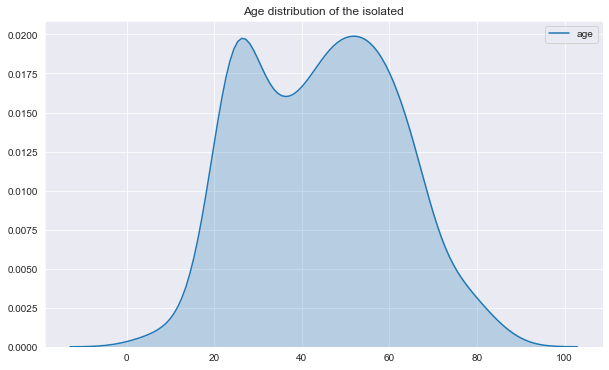

In [26]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the isolated")
sns.kdeplot(data=isolated_state['age'], shade=True)

**Age distribution of death**

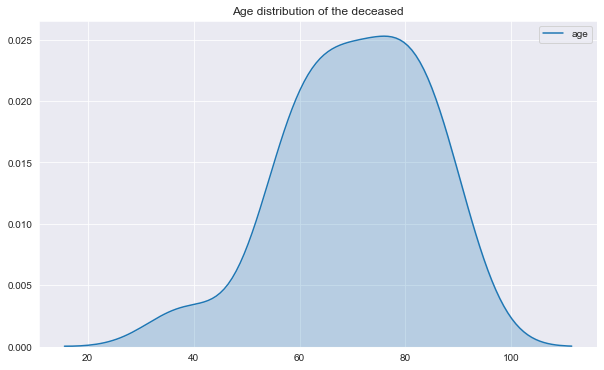

In [27]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased")
sns.kdeplot(data=dead['age'], shade=True)

In [28]:
male_dead = dead[dead.sex=='male']
female_dead = dead[dead.sex=='female']

**Age distribution of death by gender**

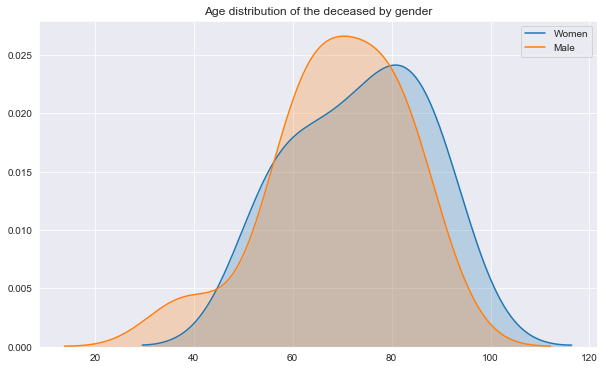

In [29]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased by gender")
sns.kdeplot(data=female_dead['age'], label="Women", shade=True)
sns.kdeplot(data=male_dead['age'],label="Male" ,shade=True)



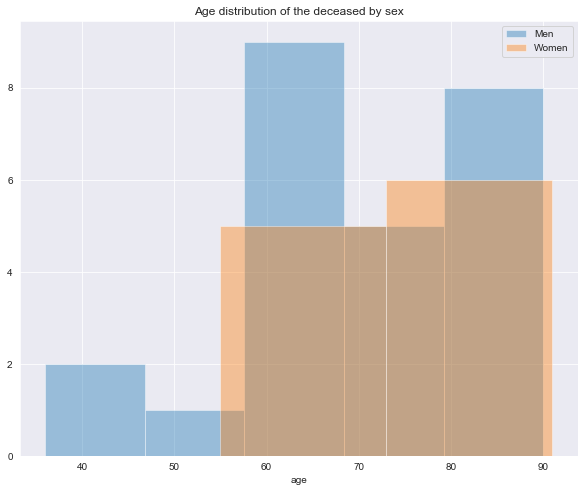

In [30]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.distplot(a=male_dead['age'], label="Men", kde=False)
sns.distplot(a=female_dead['age'], label="Women", kde=False)
plt.title("Age distribution of the deceased by sex")
plt.legend()

                                      ** Age distribution of deceased **
 Here, the graph shows the age distribution of the deceased by gender. We can clearly see older people are more likely to be infected, especially older people with underlying lung disease and having problems in their respiration. The age group of 60 to 70 yr are more infected than the rest of the population. As  Dr. Steven Gambert, professor of medicine and director of geriatrics at the University of Maryland School of Medicine says “ Older people have  higher risk of underlying health conditions, older people are already under physical stress, and their immune systems, even if not significantly compromised, simply do not have the same “ability to fight viruses and bacteria”

                                    **Gender distribution of deceased **
The graph shows the age distribution of deceased gender where men are more likely to die from coronavirus  than women. New research  has found that men, particularly middle-aged and older men, are having a harder time fighting off the virus than women. Chinese researchers found that while the infection rate among men and women is the same, the death rate among men is 2.8% compared with 1.7% for women. As there are a few reasons men are more likely to die from the new coronavirus. Women have a heightened immune response. During Middle East respiratory syndrome coronavirus 32% of men died of the infection compared with 25.8% of women. 

**Comparison of released and deceased by age**

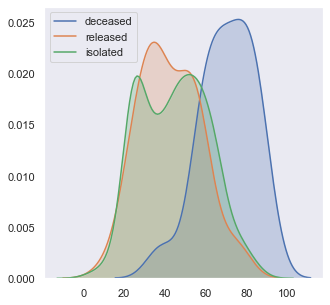

In [101]:
sns.kdeplot(data=dead['age'],label='deceased', shade=True)
sns.kdeplot(data=released['age'],label='released', shade=True)
sns.kdeplot(data=isolated_state['age'],label='isolated', shade=True)

**Death by gender**

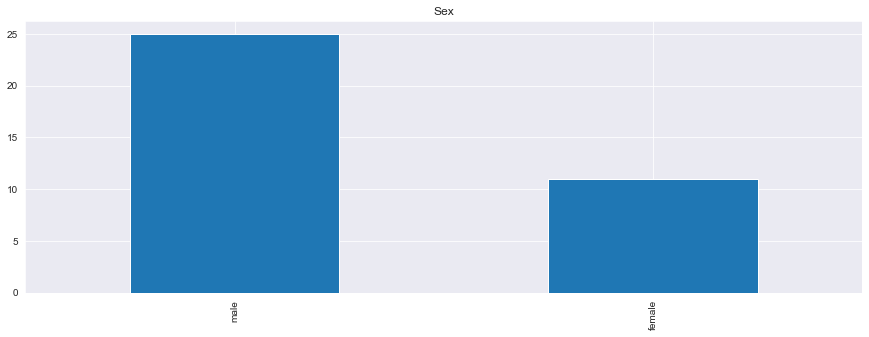

In [32]:
plt.figure(figsize=(15, 5))
plt.title('Sex')
dead.sex.value_counts().plot.bar();

In [33]:
fig = px.pie( values=dead.groupby(['sex']).size().values,names=dead.groupby(['sex']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**Isolation by gender**

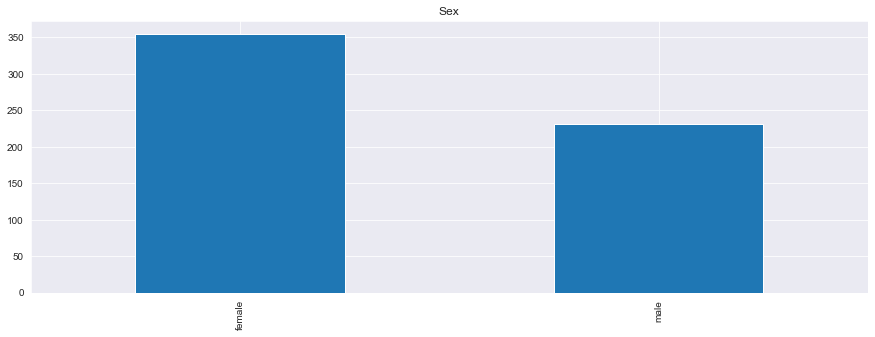

In [34]:
plt.figure(figsize=(15, 5))
plt.title('Sex')
isolated_state.sex.value_counts().plot.bar();

In [35]:
fig = px.pie( values=isolated_state.groupby(['sex']).size().values,names=isolated_state.groupby(['sex']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**Recovery by gender**

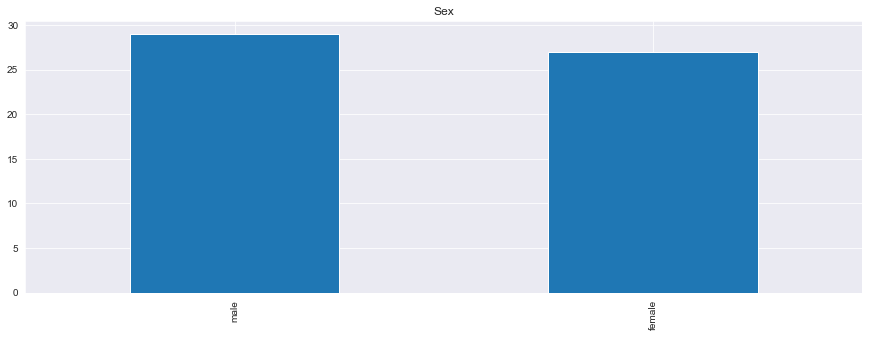

In [36]:
plt.figure(figsize=(15, 5))
plt.title('Sex')
released.sex.value_counts().plot.bar();

In [37]:
fig = px.pie( values=released.groupby(['sex']).size().values,names=released.groupby(['sex']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**Reason for the infection**

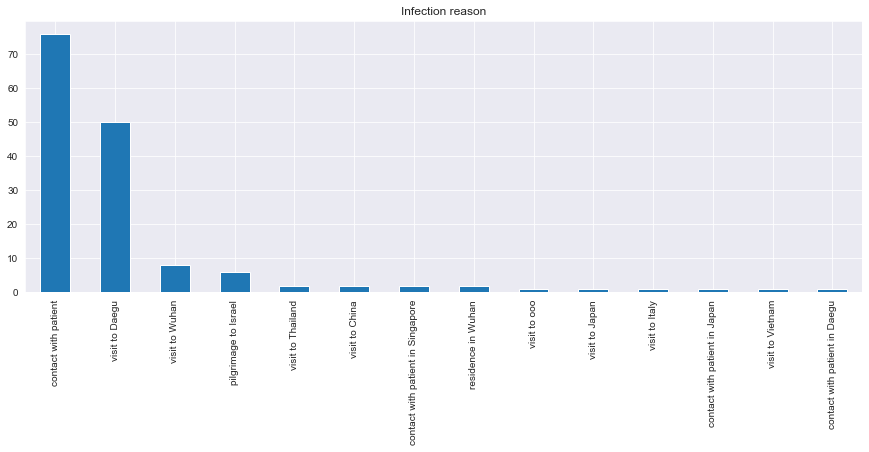

In [38]:
plt.figure(figsize=(15,5))
plt.title('Infection reason')
df_patient.infection_reason.value_counts().plot.bar();

In [39]:
fig = px.pie( values=df_patient.groupby(['infection_reason']).size().values,names=df_patient.groupby(['infection_reason']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**There are many effective reasons for the coronavirus infection. There is no specific antiviral treatment recommended for COVID-19. People with COVID-19 should receive supportive care to help relieve symptoms. For severe cases, treatment should include care to support vital organ functions.People who think they may have been exposed to COVID-19 should contact their healthcare provider immediately.  According to the dataset the major reason for the infection is being in contact with patients. There are so many different reasons for the cause of infection which are visits to countries and regions like daegu, wuhan, thailand, china, vietnam, italy.**

C:\Users\Student\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



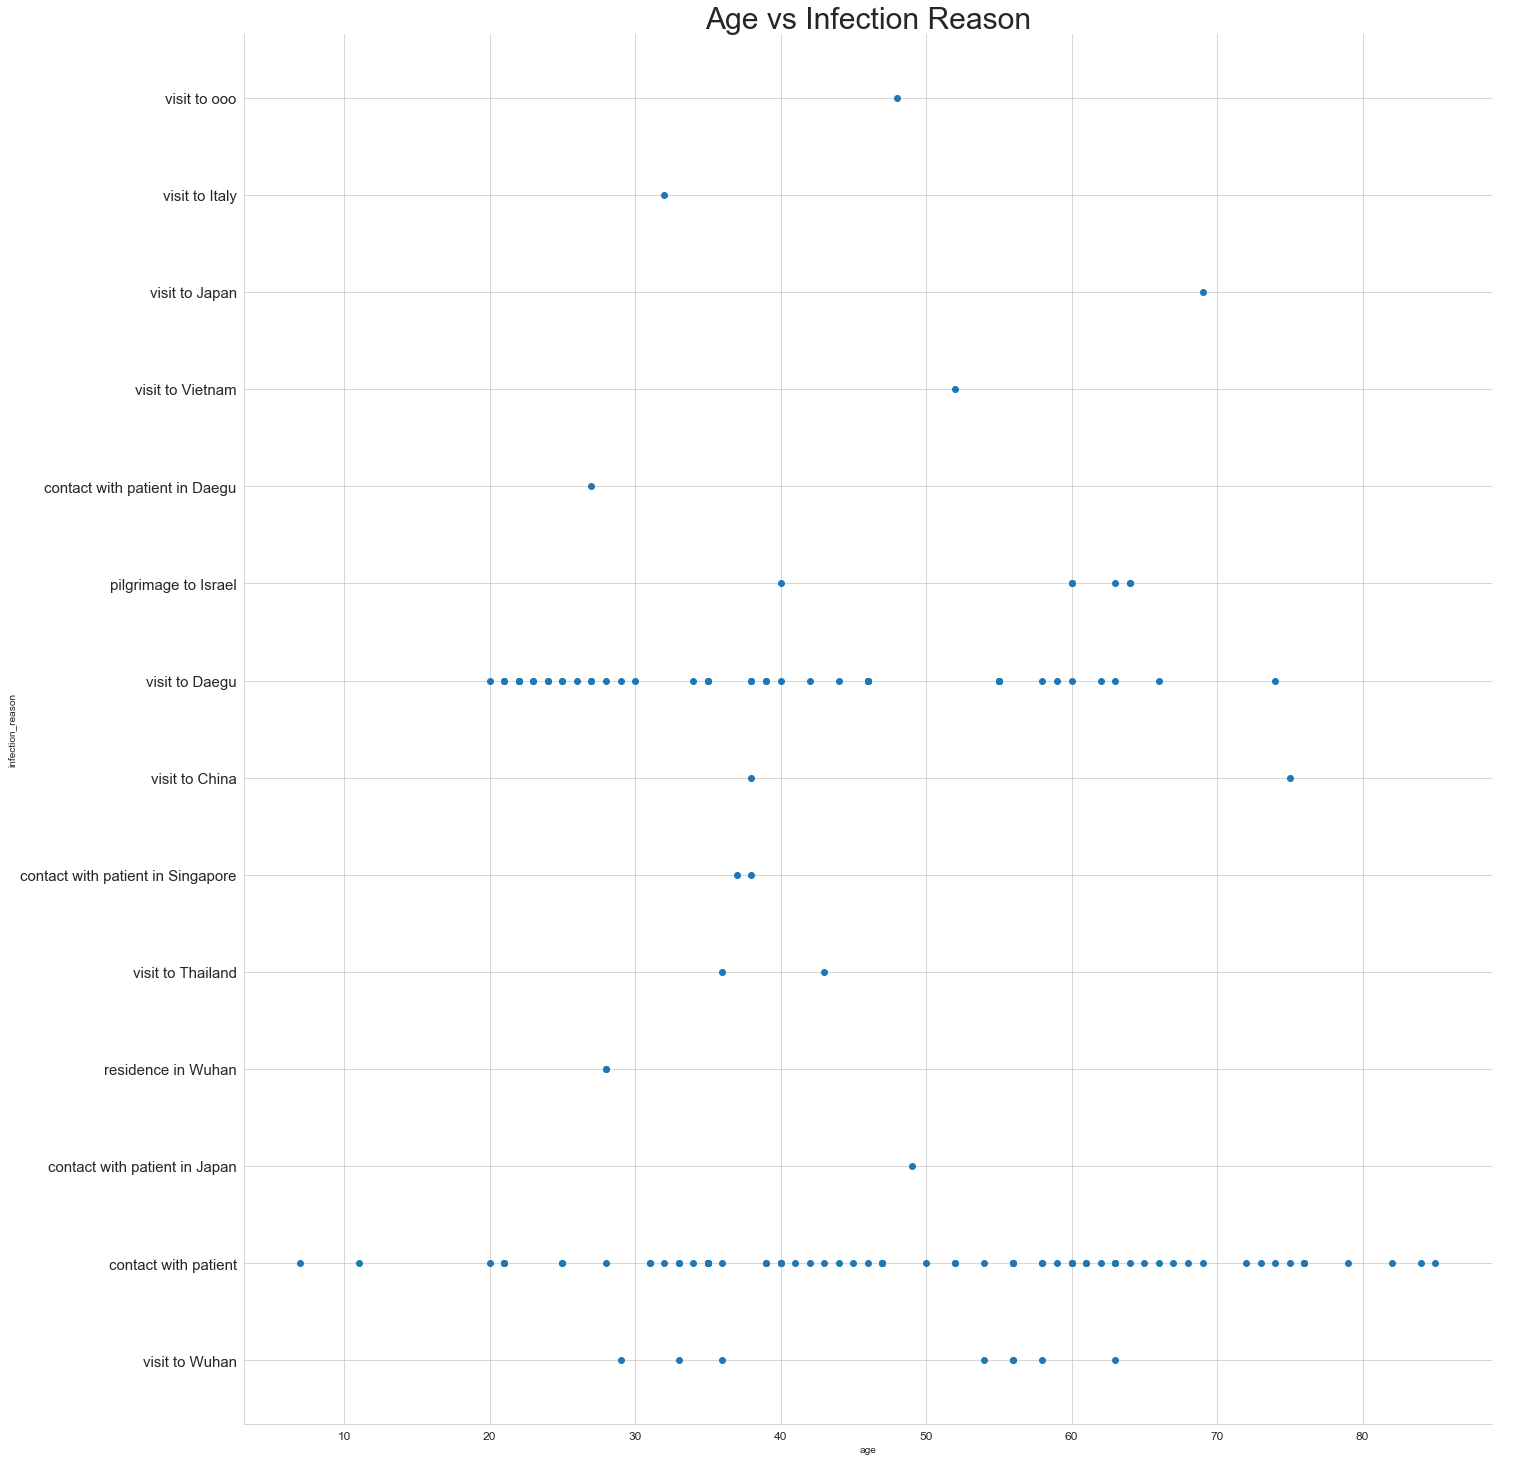

In [40]:
sns.set_style("whitegrid")
sns.FacetGrid(df_patient,  size = 20)\
.map(plt.scatter, 'age', 'infection_reason')\
.add_legend()
plt.title('Age vs Infection Reason',fontsize=30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.show()

**State of Patient**

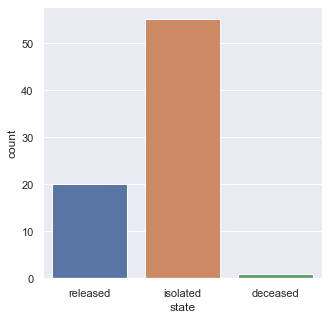

In [41]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[
    (df_patient['infection_reason']=='contact with patient')
])

In [42]:
fig = px.pie( values=df_patient.groupby(['state']).size().values,names=df_patient.groupby(['state']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**State of male patient**

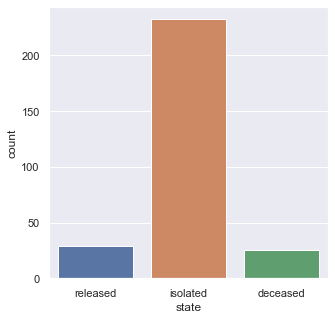

In [43]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="male")])

**State of female patient**

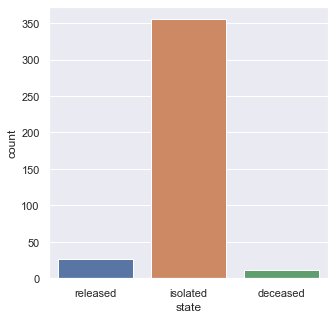

In [44]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="female")])

The first case of coronavirus in the country on January 20. At the moment, 31 patients were discharged from hospitals after making a full recovery from the virus and 22 deaths are reported. In total, over 105 thousand people have been tested until now. 

**State of patient(male and female) vs age **

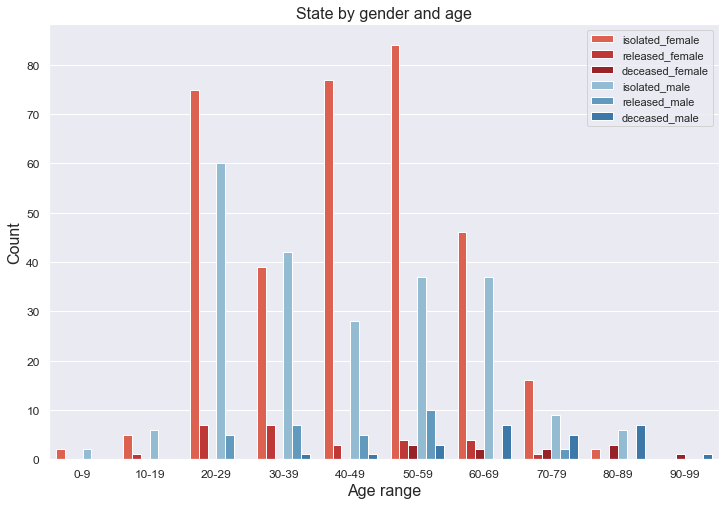

In [45]:
age_gender_hue_order =["isolated_female", "released_female", "deceased_female",
                       "isolated_male", "released_male", "deceased_male"]
custom_palette = sns.color_palette("Reds")[3:6] + sns.color_palette("Blues")[2:5]

plt.figure(figsize=(12, 8))
sns.countplot(x = "age_range",
              hue="state_by_gender",
              order=age_ranges,
              hue_order=age_gender_hue_order,
              palette=custom_palette,
              data=patient)
plt.title("State by gender and age", fontsize=16)
plt.xlabel("Age range", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right")
plt.show()

**Region by age and state**

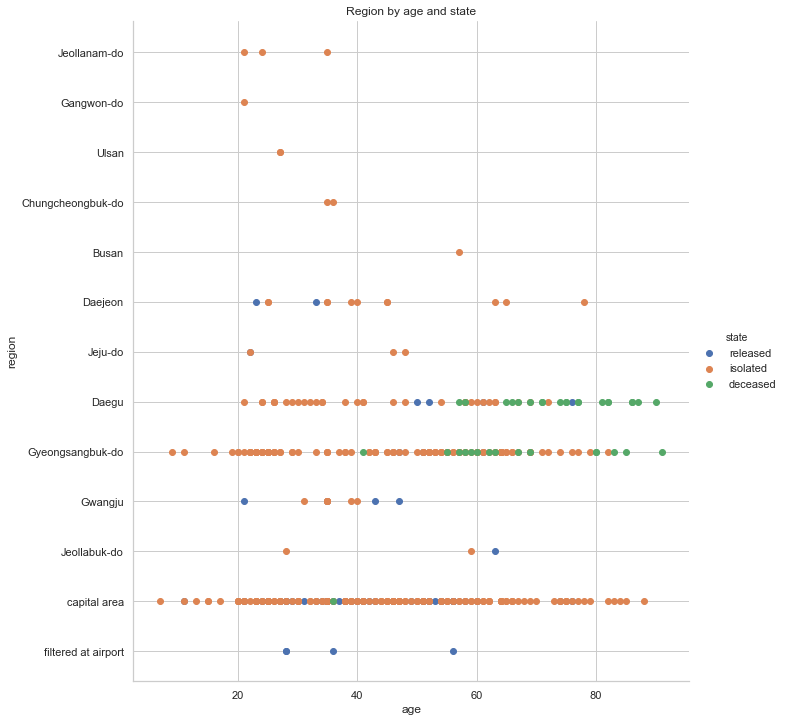

In [46]:
sns.set_style("whitegrid")
sns.FacetGrid(df_patient, hue = 'state', size = 10)\
.map(plt.scatter, 'age', 'region')\
.add_legend()
plt.title('Region by age and state')
plt.show()

**Looking route data**

In [47]:
df_route.head()

patient_id        date     province      city              visit  \
0           1  2020-01-19      Incheon   Jung-gu            airport   
1           1  2020-01-20      Incheon    Seo-gu  hospital_isolated   
2           2  2020-01-22  Gyeonggi-do  Gimpo-si            airport   
3           2  2020-01-23        Seoul   Jung-gu  hospital_isolated   
4           3  2020-01-20      Incheon   Jung-gu            airport   

    latitude   longitude  
0  37.460459  126.440680  
1  37.478832  126.668558  
2  37.562143  126.801884  
3  37.567454  127.005627  
4  37.460459  126.440680

**Checking if is there any null value**

In [48]:
df_route.isna().sum()

patient_id    0
date          0
province      0
city          0
visit         0
latitude      0
longitude     0
dtype: int64

In [49]:
clus=df_route.loc[:,['patient_id','latitude','longitude']]
clus.head(10)

patient_id   latitude   longitude
0           1  37.460459  126.440680
1           1  37.478832  126.668558
2           2  37.562143  126.801884
3           2  37.567454  127.005627
4           3  37.460459  126.440680
5           3  37.524978  127.027718
6           3  37.503359  127.049177
7           3  37.524669  127.015911
8           3  37.529200  127.032597
9           3  37.674192  126.776955

**Checking for number of cluster**

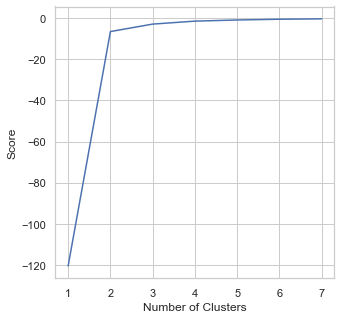

In [50]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()



As in this graph, after 5 score go to constant value, so we will go with 5 clusters

In [51]:
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

**Graphical representation of clusters**

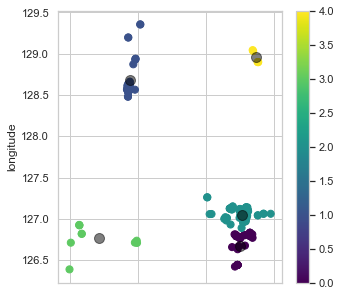

In [52]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

**We will verify our clusters by putting values in world map by making use of folium library**

**Affected place in world map**

In [53]:

 import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(df_route['latitude'], df_route['longitude'],df_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

On the world map it can clearly be seen that the western side of the country is more affected. The number of cases from Daegu and Gyeongbuk accounts for almost 88 percent of the total infections. This is closely linked to a religious group called Shincheonji Church of Jesus based in Daegu, where a collective infection has occurred and is spreading throughout the country.  About 60 percent of all infections in South Korea were related to Shincheonji. There have also been several deaths from a hospital linked to this religious group. The government of South Korea announced that it will test all over 200 thousand members of the group for the coronavirus. Over 70 countries are restricting entry from South korea. South Korea has the most cases after China.  South Korea reported the first case on 19th of feb.The cases increased multifold on 21 February, the majority of them being reported in the city of Daegu. The increase was due to community spread, traced to a church in Shincheonji, alarming the Korean health authorities. Singapore too is facing a similar surge in community spread of the novel coronavirus. Seoul city mayor Park Won-soon demanded to prosecute some of the key leaders of the Shincheonji Church for hiding the identities of the suspects during contact tracing investigation.The alert level was further raised to Orange (Level 3) on 28 January. Furthermore, 29 national designated hospitals were announced to isolate the confirmed and suspected cases

**Patient in city**

In [54]:
df_route

patient_id        date          province           city  \
0             1  2020-01-19           Incheon        Jung-gu   
1             1  2020-01-20           Incheon         Seo-gu   
2             2  2020-01-22       Gyeonggi-do       Gimpo-si   
3             2  2020-01-23             Seoul        Jung-gu   
4             3  2020-01-20           Incheon        Jung-gu   
..          ...         ...               ...            ...   
207          55  2020-02-19  Gyeongsangbuk-do      Pohang-si   
208          56  2020-02-17  Gyeongsangbuk-do      Pohang-si   
209          56  2020-02-13             Seoul  Dongdaemun-gu   
210          56  2020-02-13             Seoul      Jongno-gu   
211          56  2020-02-19             Seoul    Jungnang-gu   

                 visit   latitude   longitude  
0              airport  37.460459  126.440680  
1    hospital_isolated  37.478832  126.668558  
2              airport  37.562143  126.801884  
3    hospital_isolated  37.567454  127.005627  
4              airport  37.460459  126.440680  
..                 ...        ...         ...  
207  hospital_isolated  36.034762  129.355059  
208           hospital  37.576420  126.972759  
209           hospital  37.593919  127.051291  
210           hospital  37.581837  126.969186  
211  hospital_isolated  37.612806  127.098134  

[212 rows x 7 columns]

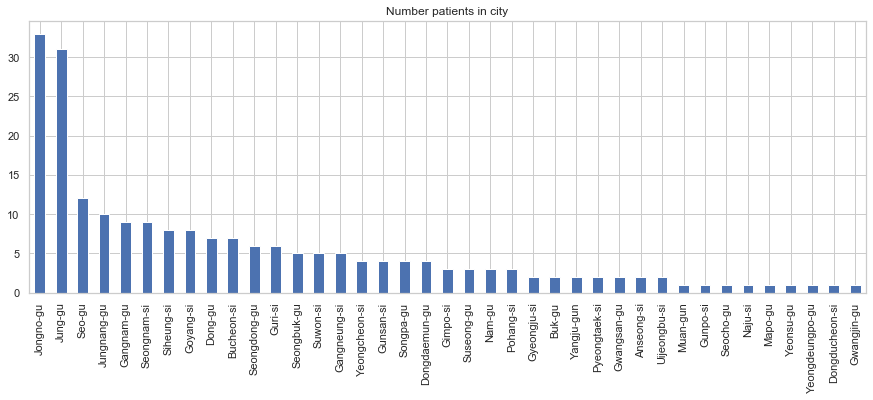

In [55]:
plt.figure(figsize=(15,5))
plt.title('Number patients in city')
df_route.city.value_counts().plot.bar();

In [56]:
fig = px.pie(values=df_route.groupby(['city']).size().values,names=df_route.groupby(['city']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**Patients in Provience/State**

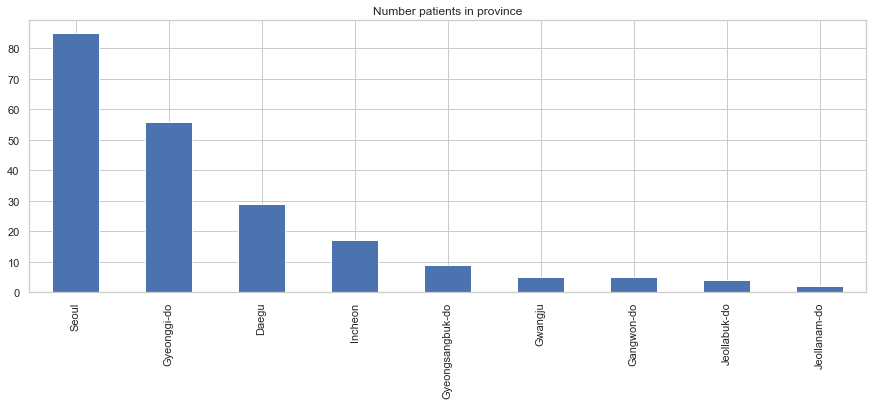

In [57]:
plt.figure(figsize=(15,5))
plt.title('Number patients in province')
df_route.province.value_counts().plot.bar();

In [58]:
fig = px.pie( values=df_route.groupby(['province']).size().values,names=df_route.groupby(['province']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**Places where people get affected**

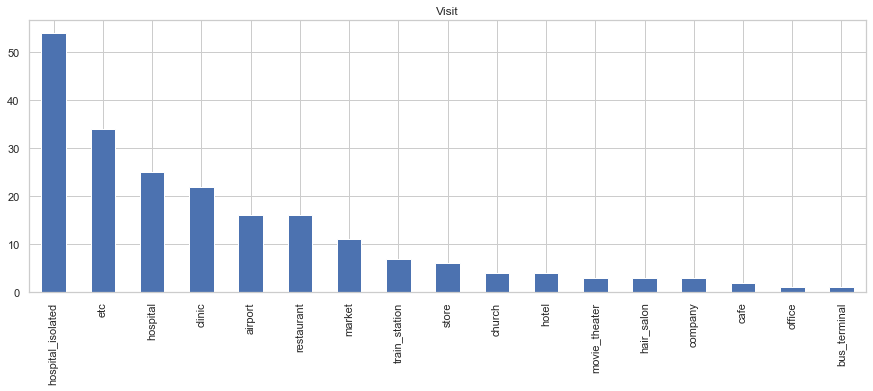

In [59]:
plt.figure(figsize=(15,5))
plt.title('Visit')
df_route.visit.value_counts().plot.bar();


In [60]:
fig = px.pie( values=df_route.groupby(['visit']).size().values,names=df_route.groupby(['visit']).size().index)
fig.update_layout(
    font=dict(
        size=15,
        color="#242323"
    )
    )   
    
py.iplot(fig)

**Time from confirmation to release or death**

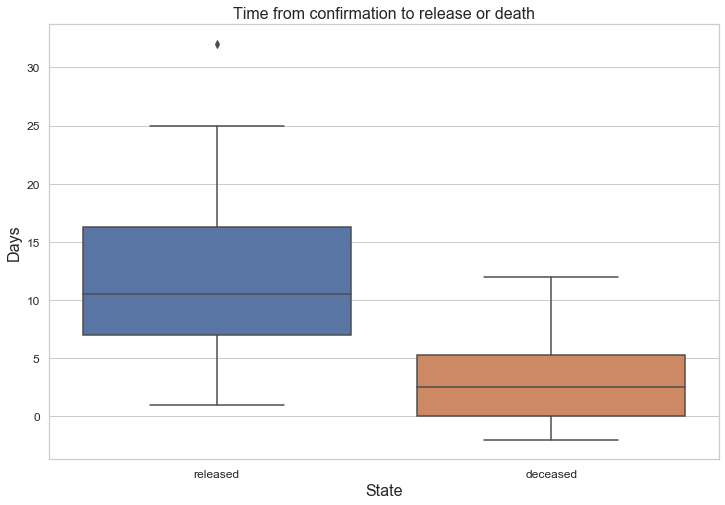

In [61]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="state",
            y="duration_days",
            order=["released", "deceased"],
            data=patient)
plt.title("Time from confirmation to release or death", fontsize=16)
plt.xlabel("State", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Time from confirmation to release or death by gender**

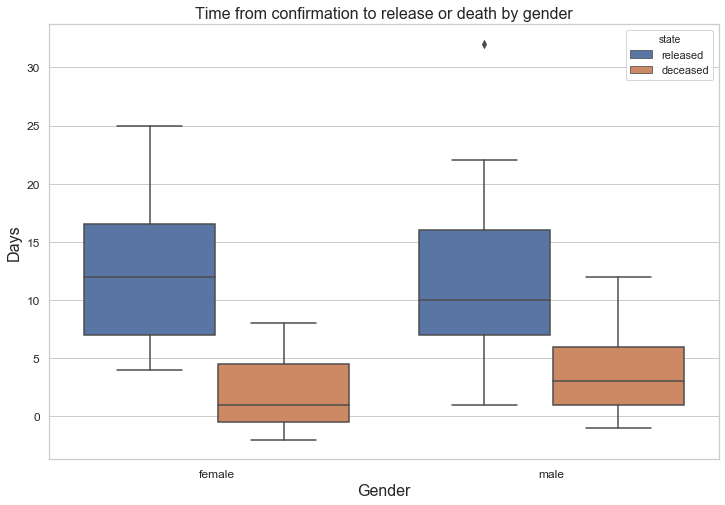

In [62]:
order_duration_sex = ["female", "male"]
plt.figure(figsize=(12, 8))
sns.boxplot(x="sex",
            y="duration_days",
            order=order_duration_sex,
            hue="state",            
            hue_order=["released", "deceased"],
            data=patient)
plt.title("Time from confirmation to release or death by gender",
          fontsize=16)
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Time from confirmation to release or death**

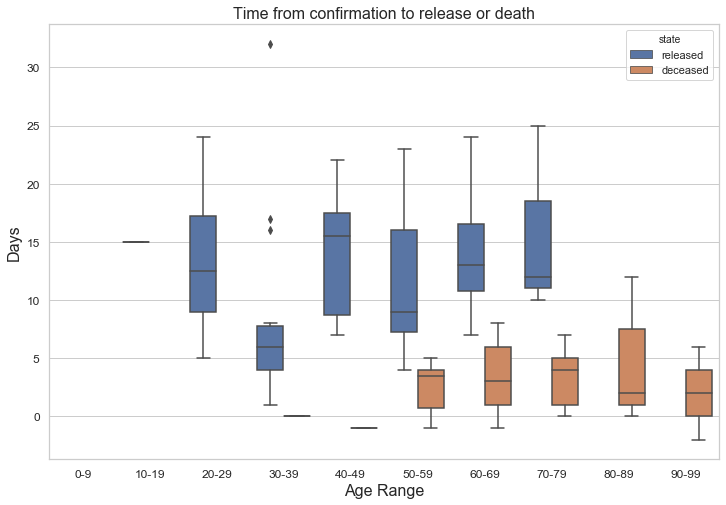

In [63]:
order_duration_age = sorted(patient["age_range"].unique())[:-1]
plt.figure(figsize=(12, 8))
sns.boxplot(x="age_range",
            y="duration_days",
            order=order_duration_age,
            hue="state",
            hue_order=["released", "deceased"],
            data=patient)
plt.title("Time from confirmation to release or death", fontsize=16)
plt.xlabel("Age Range", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As the suspects of coronavirus are kept under observation. After the observation it has been found that the people who are released or who have great chances of recovery had sustained  10-20 days in hospitals. On the other hand the people who are deceased were found dead in 0-4 days.The deadly Coronavirus which has spread to more than 70 countries, is wreaking havoc globally, killing over 3,000 people and infecting almost 90,000 people since first detected in China in December last year. While Australia and the US reported their first deaths yesterday,

**Making data ready for prediction**

In [64]:
data = daily_count.resample('D').first().fillna(0).cumsum()
data = data[20:]
x = np.arange(len(data)).reshape(-1, 1)
y = data.values

**Regression Model**

In [65]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

In [66]:
test = np.arange(len(data)+7).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
week = [data.index[0] + timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.Series(prediction, dt_idx)

**Graphical representation of current confirmed and predicted confirmed**

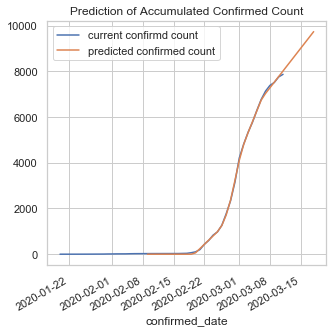

In [67]:
accumulated_count.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

**Prophet**

In [68]:
prophet= pd.DataFrame(data)
prophet
pr_data = prophet.reset_index()
pr_data.columns = ['ds','y']
pr_data.head()

ds     y
0 2020-02-09  27.0
1 2020-02-10  28.0
2 2020-02-11  28.0
3 2020-02-12  28.0
4 2020-02-13  28.0

**Prediction**

In [69]:
m=Prophet()
m.fit(pr_data)
future=m.make_future_dataframe(periods=15)
forecast=m.predict(future)
forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds         trend   yhat_lower    yhat_upper   trend_lower  \
0  2020-02-09  -2024.995466 -3124.165638   -252.484111  -2024.995466   
1  2020-02-10  -1728.671275 -2916.889334     63.264700  -1728.671275   
2  2020-02-11  -1432.347084 -2797.240551     49.784440  -1432.347084   
3  2020-02-12  -1136.022892 -2595.326952    275.011503  -1136.022892   
4  2020-02-13   -839.698701 -2578.733738    380.883645   -839.698701   
5  2020-02-14   -543.374510 -2213.539720    570.719725   -543.374510   
6  2020-02-15   -247.050319 -1832.467142    878.449360   -247.050319   
7  2020-02-16     49.273873 -1002.855935   1827.261492     49.273873   
8  2020-02-17    345.598064  -875.827306   1825.017328    345.598064   
9  2020-02-18    641.922255  -723.207842   2206.685773    641.922255   
10 2020-02-19    938.246447  -503.242943   2269.930530    938.246447   
11 2020-02-20   1234.570695  -504.401439   2453.366201   1234.570695   
12 2020-02-21   1530.902240  -210.529199   2747.458053   1530.902240   
13 2020-02-22   1827.243131   155.131624   3080.860012   1827.243131   
14 2020-02-23   2123.609013  1090.992162   3862.569331   2123.609013   
15 2020-02-24   2419.989165  1189.248298   4112.264954   2419.989165   
16 2020-02-25   2716.461012  1308.473515   4187.468380   2716.461012   
17 2020-02-26   3012.997937  1542.150698   4359.991108   3012.997937   
18 2020-02-27   3309.540266  1580.821567   4530.641843   3309.540266   
19 2020-02-28   3606.082605  1983.948250   4919.560760   3606.082605   
20 2020-02-29   3902.624970  2300.968666   5227.008458   3902.624970   
21 2020-03-01   4199.167358  3046.973546   5893.393863   4199.167358   
22 2020-03-02   4495.709747  3336.022672   6184.326882   4495.709747   
23 2020-03-03   4792.252135  3444.318081   6335.285097   4792.252135   
24 2020-03-04   5088.794524  3676.053180   6558.893961   5088.794524   
25 2020-03-05   5385.336912  3699.840466   6484.300244   5385.336912   
26 2020-03-06   5681.879300  4048.928653   6811.459060   5681.879300   
27 2020-03-07   5978.421689  4357.166680   7120.888464   5978.421689   
28 2020-03-08   6274.964077  5171.929778   8172.328149   6274.964077   
29 2020-03-09   6571.506466  5384.916661   8144.017093   6571.506466   
30 2020-03-10   6868.048854  5448.318423   8443.126933   6868.048854   
31 2020-03-11   7164.591243  5714.091946   8587.684095   7164.591243   
32 2020-03-12   7461.133631  5801.301644   8747.822273   7461.128697   
33 2020-03-13   7757.676019  6064.263560   8928.321390   7757.657246   
34 2020-03-14   8054.218408  6382.353239   9278.154517   8054.182204   
35 2020-03-15   8350.760796  7310.479469  10102.142927   8350.705064   
36 2020-03-16   8647.303185  7431.859812  10267.626420   8647.223371   
37 2020-03-17   8943.845573  7555.515194  10372.424186   8943.738660   
38 2020-03-18   9240.387962  7809.719090  10504.189094   9240.257561   
39 2020-03-19   9536.930350  7864.756139  10680.391265   9536.771081   
40 2020-03-20   9833.472738  8333.392338  10928.885030   9833.277814   
41 2020-03-21  10130.015127  8524.257113  11459.650588  10129.782150   
42 2020-03-22  10426.557515  9372.498612  12178.139517  10426.285731   
43 2020-03-23  10723.099904  9560.032565  12409.456593  10722.786987   
44 2020-03-24  11019.642292  9720.271922  12508.561117  11019.283773   
45 2020-03-25  11316.184680  9761.634006  12771.941214  11315.785092   
46 2020-03-26  11612.727069  9927.500100  12858.568982  11612.288882   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   -2024.995466      326.093365            326.093365            326.093365   
1   -1728.671275      222.253296            222.253296            222.253296   
2   -1432.347084      107.792872            107.792872            107.792872   
3   -1136.022892      -15.481325            -15.481325            -15.481325   
4    -839.698701     -226.760077           -226.760077           -226.760077   
5    -543.374510     -234.717793           -234.717793           -234.7177

**Graphical Representation of Prediction**

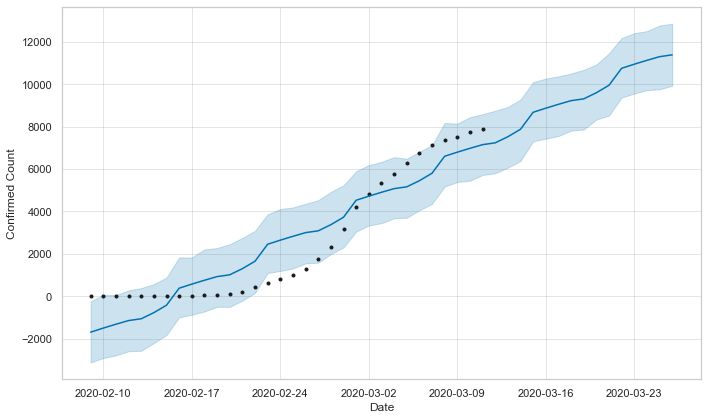

In [70]:
figure = plot_plotly(m, forecast)
py.iplot(figure) 

figure = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')


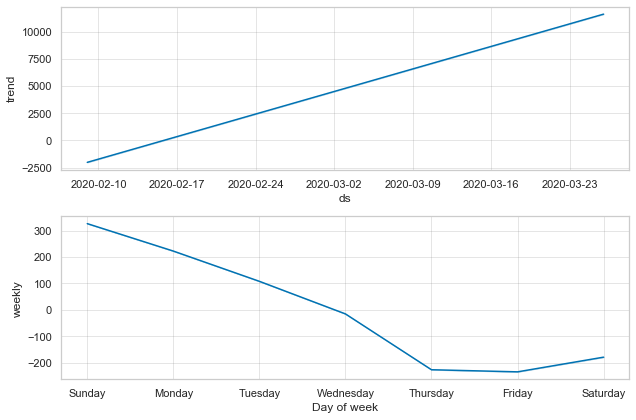

In [71]:
figure=m.plot_components(forecast)


**Autoregressive integrated moving average(Arima)**

In [72]:
confirm_cs = pd.DataFrame(data).cumsum()
arima_data = confirm_cs.reset_index()
arima_data.columns = ['confirmed_date','count']
arima_data.head()

confirmed_date  count
0     2020-02-09   27.0
1     2020-02-10   55.0
2     2020-02-11   83.0
3     2020-02-12  111.0
4     2020-02-13  139.0

In [73]:
model = ARIMA(arima_data['count'].values, order=(1, 2, 1))
fit_model = model.fit(trend='c', full_output=True, disp=True)
fit_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   30
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -189.160
Method:                       css-mle   S.D. of innovations            129.384
Date:                Thu, 30 Apr 2020   AIC                            386.320
Time:                        17:05:23   BIC                            391.925
Sample:                             2   HQIC                           388.113
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.7355    143.581      1.433      0.152     -75.678     487.149
ar.L1.D2.y     0.8390      0.103      8.150      0.000       0.637       1.041
ma.L1.D2.y     0.1162      0.201      0.579      0.563      -0.277       0.510
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1919           +0.0000j            1.1919            0.0000
MA.1           -8.6041           +0.0000j            8.6041            0.5000
-----------------------------------------------------------------------------
"""

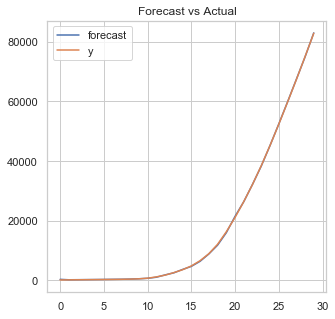

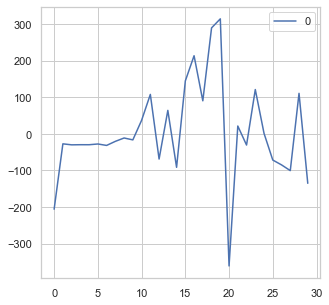

In [74]:
fit_model.plot_predict()
plt.title('Forecast vs Actual')
pd.DataFrame(fit_model.resid).plot()


**Forecasting future Values**

In [75]:
forcast = fit_model.forecast(steps=5)
pred_y = forcast[0].tolist()
pd.DataFrame(pred_y)

0
0   90834.076405
1   98944.146731
2  107194.726868
3  115596.317730
4  124157.729654

**LSTM**

In [76]:
dataset = pd.DataFrame(data)
dataset.columns = ['Confirmed']
dataset.head()

Confirmed
confirmed_date           
2020-02-09           27.0
2020-02-10           28.0
2020-02-11           28.0
2020-02-12           28.0
2020-02-13           28.0

In [77]:
data = np.array(dataset).reshape(-1, 1)
train_data = dataset[:len(dataset)-5]
test_data = dataset[len(dataset)-5:]

In [78]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input =5
n_features =1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 21)

Epoch 1/21
22/22 [==============================] - 1s 59ms/step - loss: 0.1608
Epoch 2/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0761
Epoch 3/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0386
Epoch 4/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0552
Epoch 5/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0296
Epoch 6/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 7/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0235
Epoch 8/21
22/22 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 9/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0359
Epoch 10/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 11/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0174
Epoch 12/21
22/22 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 13/21
22/22 [=============================

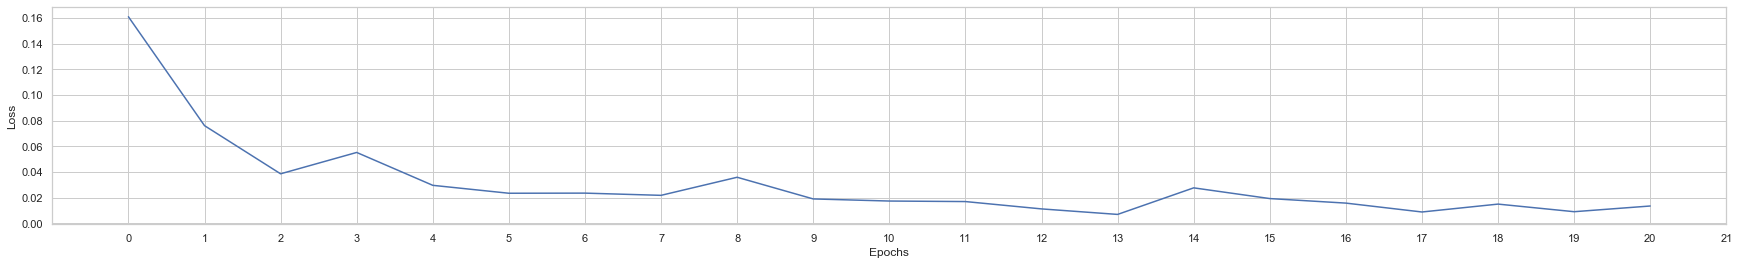

In [79]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [80]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [81]:
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction.head()

0
0   8412.258737
1   8958.440382
2   9510.822410
3  10125.834169
4  10781.305494

**Looking into time data**

In [82]:
df_time = pd.read_csv("time.csv")

In [83]:
df_time.columns

Index(['date', 'time', 'test', 'negative', 'confirmed', 'released',
       'deceased'],
      dtype='object')

In [84]:
df_time.shape

(63, 7)

In [85]:
confirm_perc=((df_time['confirmed'].sum()/(df_time['test'].sum()))*100)
              
released_perc=((df_time['released'].sum()/(df_time['test'].sum()))*100)
               
deceased_perc=((df_time['deceased'].sum()/(df_time['test'].sum()))*100)

In [86]:
print("The percentage of confirm  is "+ str(confirm_perc) )
print("The percentage of released is "+ str(released_perc) )
print("The percentage of deceased is "+ str(deceased_perc) )

The percentage of confirm  is 3.1285296002452716
The percentage of released is 0.3254168946092845
The percentage of deceased is 0.026245070349792024


**Graphical representaion of People Test and Confirmed**

In [87]:
df_time = df_time.tail(15)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


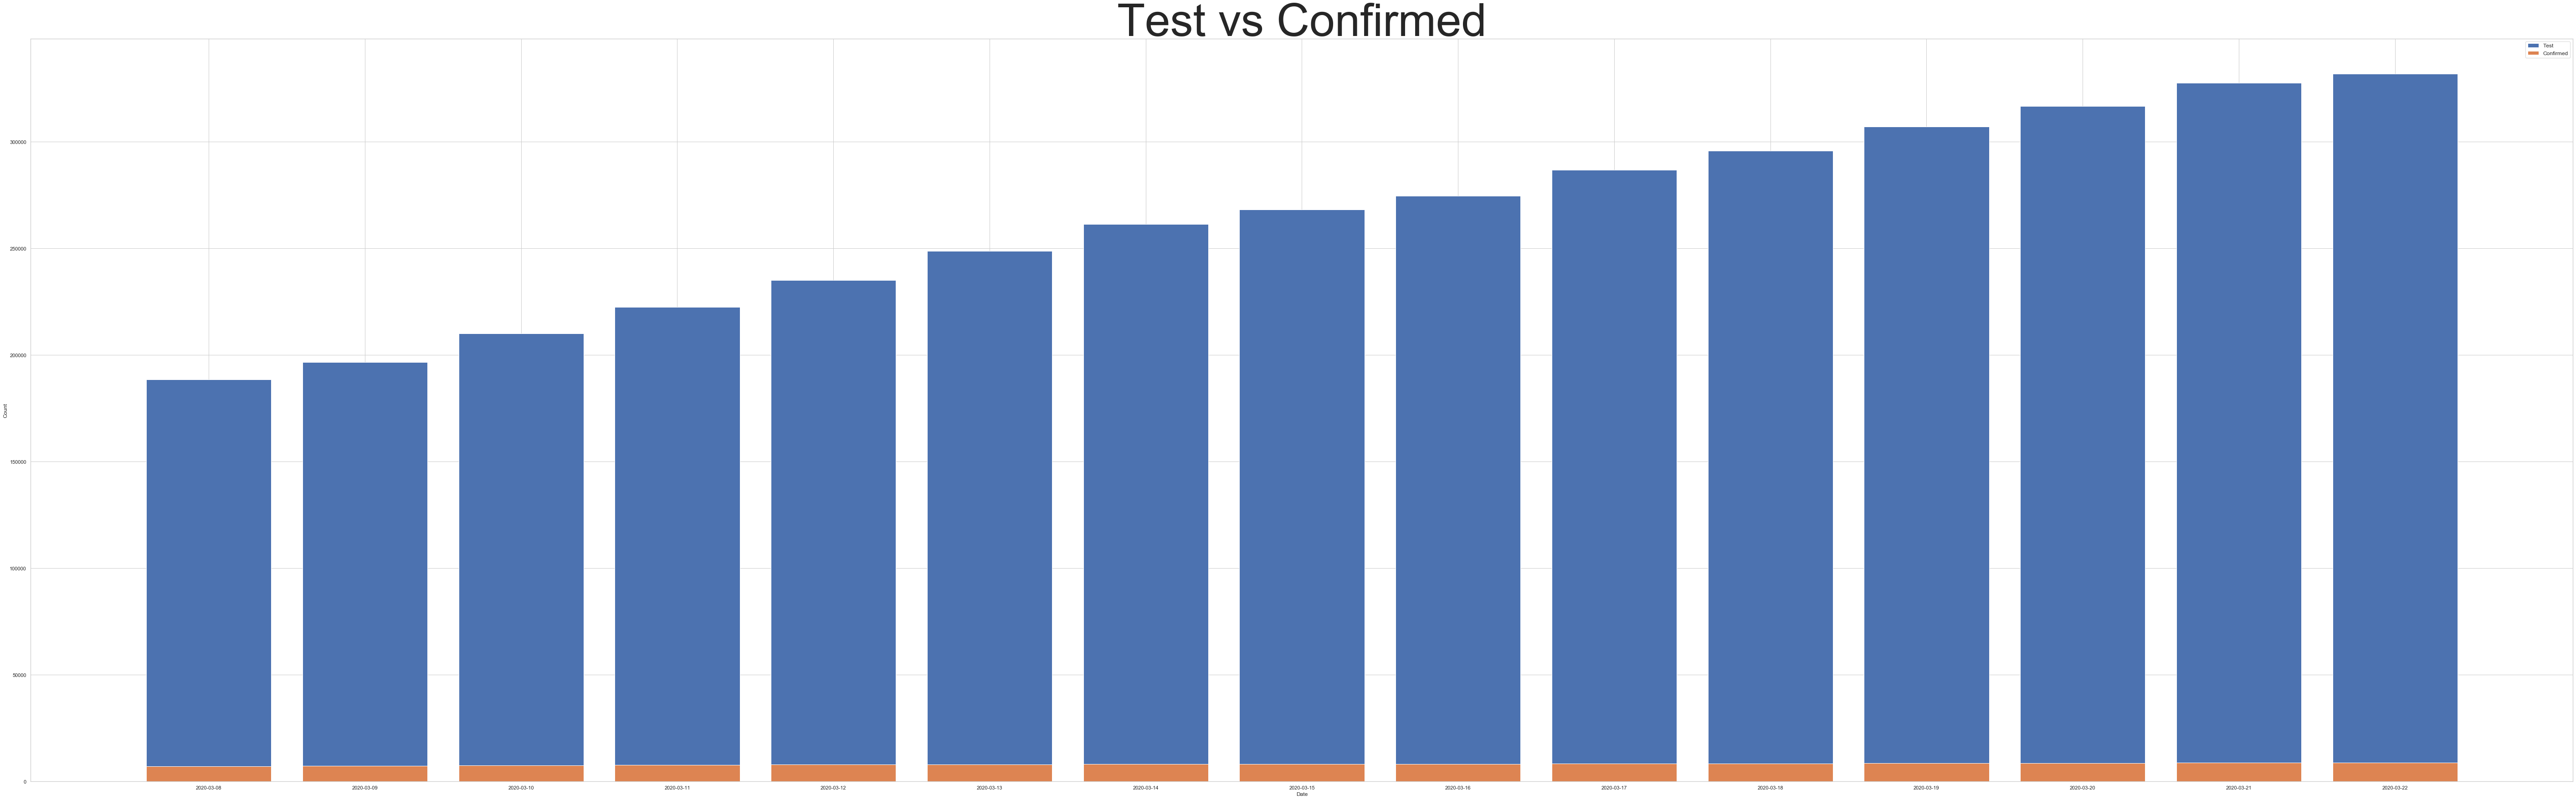

In [88]:
plt.figure(figsize=(100,30))
plt.bar(df_time.date, df_time.test,label="Test")
plt.bar(df_time.date, df_time.confirmed, label = "Confirmed")
plt.xlabel('Date')
plt.ylabel("Count")
plt.title('Test vs Confirmed',fontsize=100)
plt.legend(frameon=True, fontsize=12)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Text(0.5, 1.0, 'Test vs Confirmed')

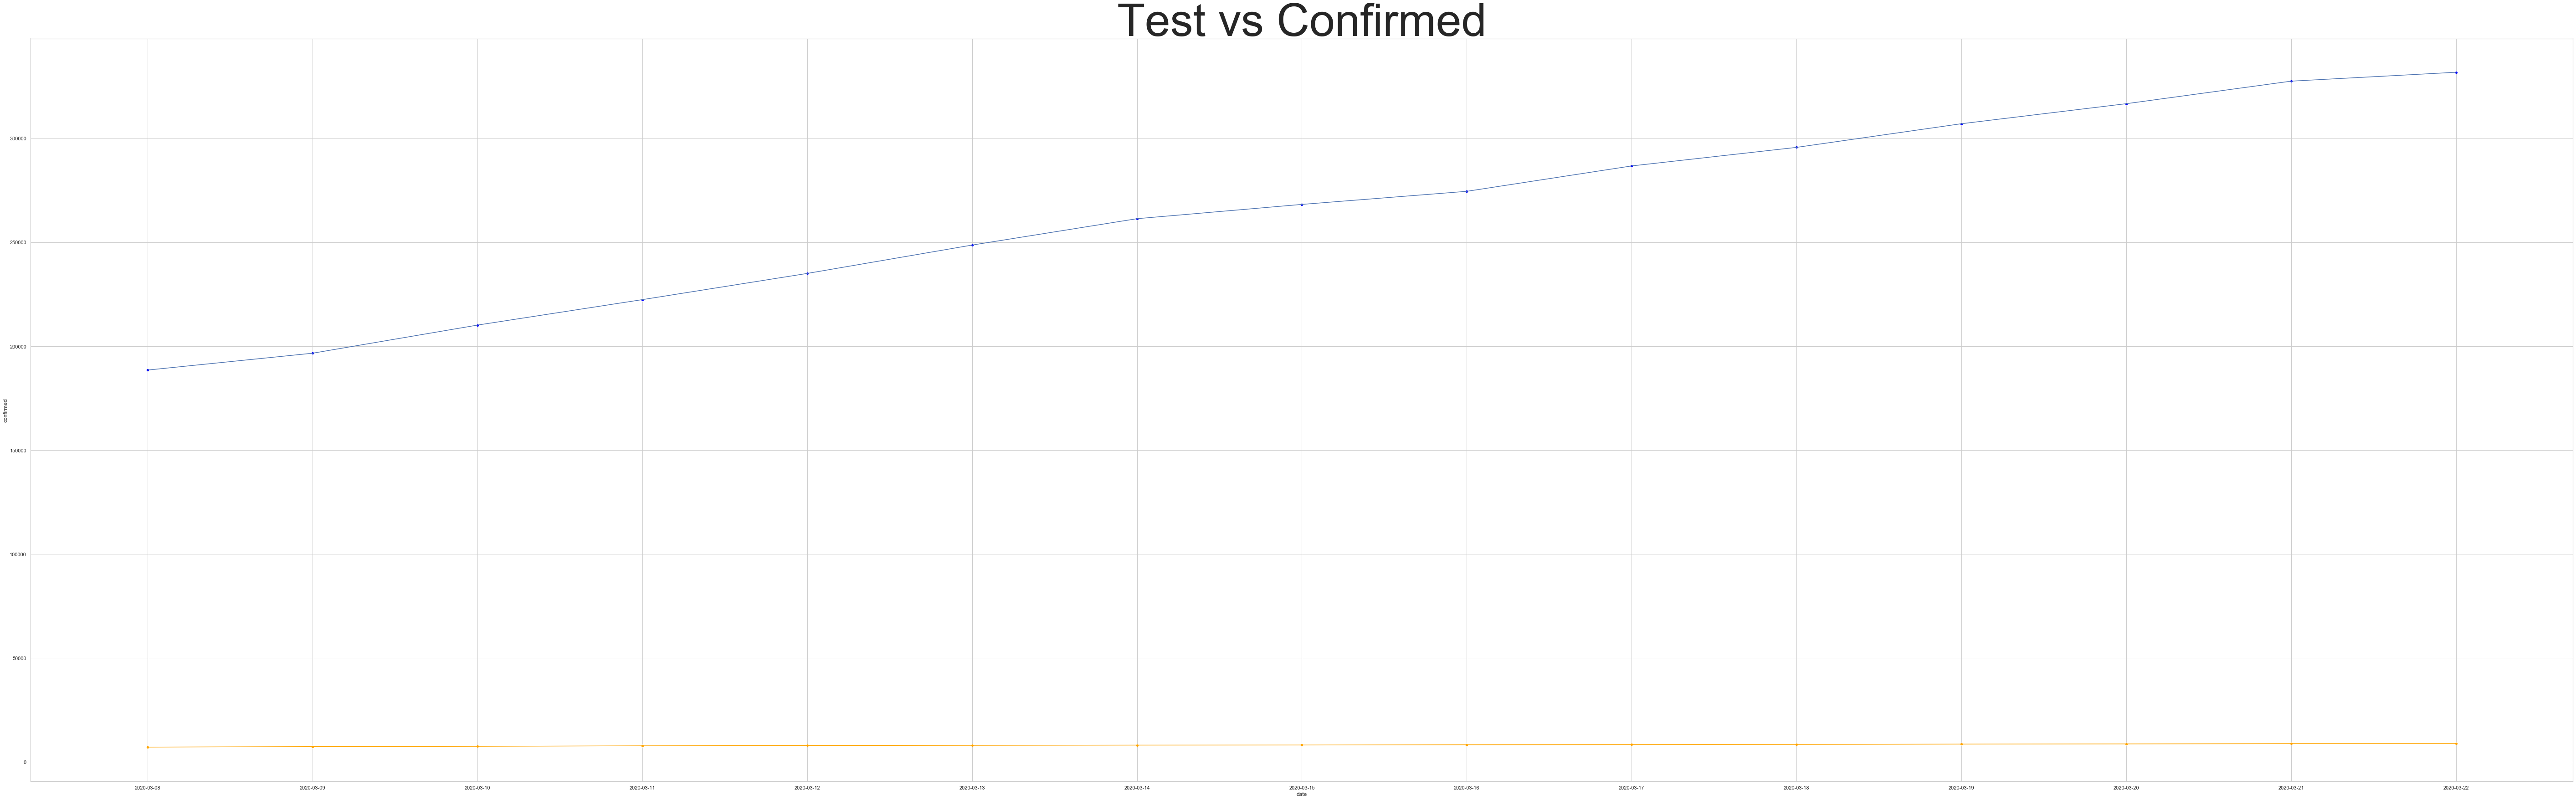

In [89]:
f, ax = plt.subplots(figsize=(100, 30))
ax=sns.scatterplot(x="date", y="test", data=df_time,
             color="blue")
ax=sns.scatterplot(x="date", y="confirmed", data=df_time,
             color="orange")


plt.plot(df_time.date,df_time.test,zorder=1)
plt.plot(df_time.date,df_time.confirmed,zorder=1,color="orange")
plt.title('Test vs Confirmed',fontsize=100)



**Graphical representaion of   Confirmed vs State of Patient **

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


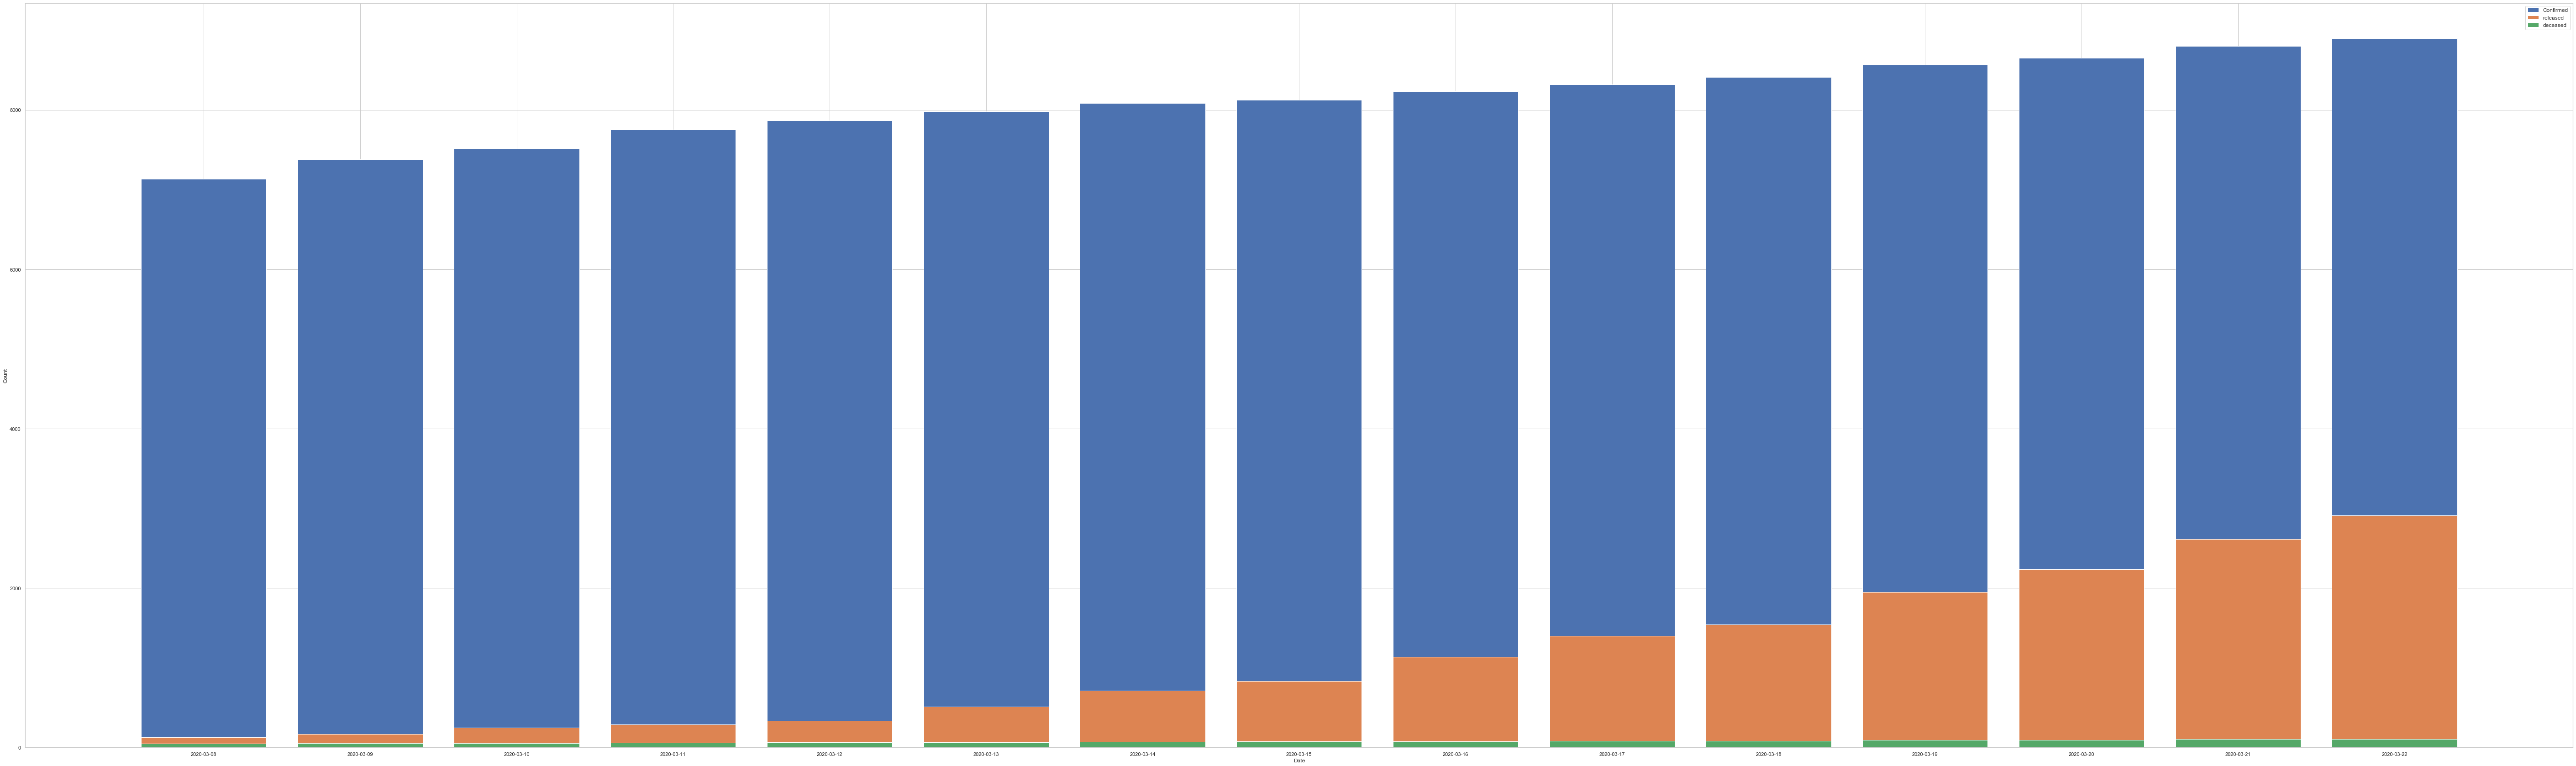

In [90]:
plt.figure(figsize=(100,30))
plt.bar(df_time.date, df_time.confirmed, label = "Confirmed")
plt.bar(df_time.date, df_time.released,label="released")
plt.bar(df_time.date, df_time.deceased,label="deceased")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.show()

**Reading file**

In [91]:
trend = pd.read_csv("trend.csv")

In [92]:
trend.head()

date     cold      flu  pneumonia  coronavirus
0  2019-12-07  0.12408  0.24699    0.22144      0.01309
1  2019-12-08  0.11863  0.25390    0.19617      0.00836
2  2019-12-09  0.16308  0.47880    0.33180      0.01272
3  2019-12-10  0.13981  0.40789    0.30671      0.01881
4  2019-12-11  0.13972  0.39007    0.30299      0.01854

**Trend data of the keywords searched in NAVER which is one of the largest portal in South Korea**

**Plotting Graph of keywork search per 100 people recently**

In [93]:
trend_last30 = trend.tail(30)
tl3 = trend_last30

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

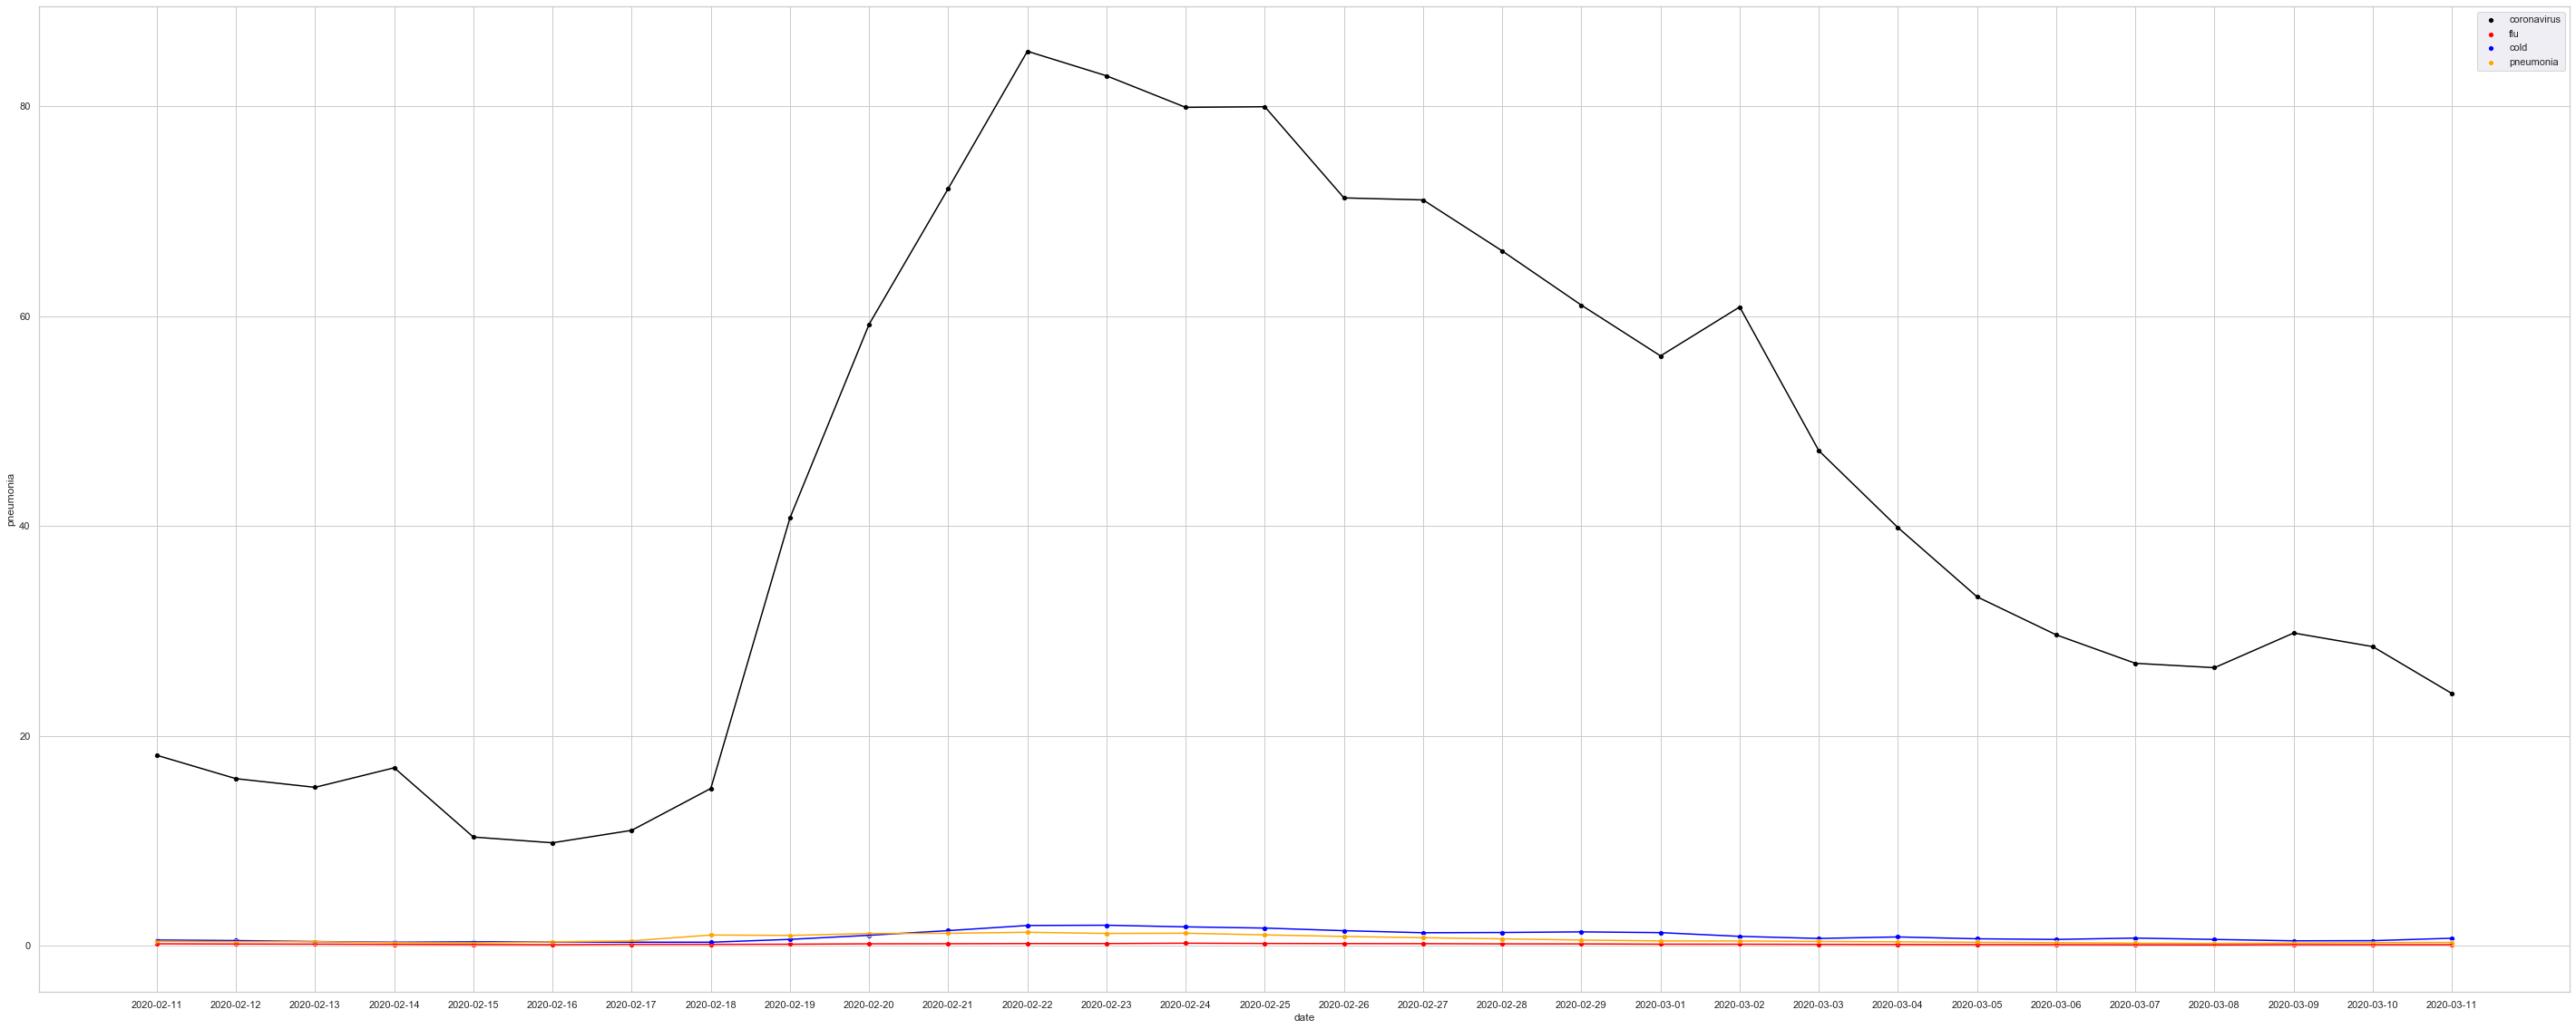

In [94]:
f, ax = plt.subplots(figsize=(50, 20))
sns.set_style("dark")
ax=sns.scatterplot(x="date", y="coronavirus", data=tl3,
             color="black",label = "coronavirus")
ax=sns.scatterplot(x="date", y="flu", data=tl3,
             color="red",label = "flu")
ax=sns.scatterplot(x="date", y="cold", data=tl3,
             color="blue",label = "cold")
ax=sns.scatterplot(x="date", y="pneumonia", data=tl3,
             color="orange",label = "pneumonia")
plt.plot(tl3.date,tl3.coronavirus,zorder=1,color="black")
plt.plot(tl3.date,tl3.cold,zorder=1,color="blue")
plt.plot(tl3.date,tl3.pneumonia,zorder=1,color="orange")
plt.plot(tl3.date,tl3.flu,zorder=1,color="red")

**Comparision with other Country**

In [95]:
comp.head()


country  Canada  China  Italy  US  Spain  Germany  Iran  France  \
0        1       0    548      0   1      0        0     0       0   
1        2       0    643      0   1      0        0     0       0   
2        3       0    920      0   2      0        0     0       2   
3        4       0   1406      0   2      0        0     0       3   
4        5       1   2075      0   5      0        0     0       3   

   United Kingdom  ...  Malaysia  Czechia  Denmark  Ireland  Luxembourg  \
0               0  ...         0        0        0        0           0   
1               0  ...         0        0        0        0           0   
2               0  ...         0        0        0        0           0   
3               0  ...         3        0        0        0           0   
4               0  ...         4        0        0        0           0   

   Japan  Ecuador  Chile  Poland  Pakistan  
0      2        0      0       0         0  
1      2        0      0       0         0  
2      2        0      0       0         0  
3      2        0      0       0         0  
4      4        0      0       0         0  

[5 rows x 32 columns]

In [96]:
comp_table = pd.DataFrame(comp.describe().T)


In [97]:
comp_table


count          mean           std    min      25%      50%  \
country          65.0     33.000000     18.907670    1.0     17.0     33.0   
Canada           65.0    304.523077    783.966798    0.0      7.0      9.0   
China            65.0  58096.923077  30155.859196  548.0  34110.0  77022.0   
Italy            65.0  11183.061538  20955.786061    0.0      3.0    155.0   
US               65.0   5737.969231  16050.951019    1.0     11.0     15.0   
Spain            65.0   5226.984615  12263.955568    0.0      1.0      2.0   
Germany          65.0   4298.523077   9817.281039    0.0     13.0     16.0   
Iran             65.0   5160.230769   8224.863815    0.0      0.0     43.0   
France           65.0   3050.061538   6575.851292    0.0      6.0     12.0   
United Kingdom   65.0   1004.800000   2398.795018    0.0      3.0      9.0   
Sweden           65.0    388.338462    722.899139    0.0      1.0      1.0   
Switzerland      65.0   1242.723077   2815.315044    0.0      0.0      0.0   
Korea, South     65.0   3219.107692   3746.532969    1.0     24.0    602.0   
Netherlands      65.0    738.123077   1644.643336    0.0      0.0      0.0   
Austria          65.0    620.107692   1476.716820    0.0      0.0      0.0   
Belgium          65.0    570.876923   1304.806721    0.0      1.0      1.0   
Turkey           65.0    186.169231    622.910095    0.0      0.0      0.0   
Portugal         65.0    271.815385    718.379293    0.0      0.0      0.0   
Norway           65.0    466.630769    881.942858    0.0      0.0      0.0   
Australia        65.0    253.246154    584.969925    0.0     15.0     15.0   
Brazil           65.0    234.753846    630.087519    0.0      0.0      0.0   
Israel           65.0    180.492308    492.072312    0.0      0.0      1.0   
Malaysia         65.0    244.000000    487.230502    0.0     12.0     22.0   
Czechia          65.0    183.815385    428.262839    0.0      0.0      0.0   
Denmark          65.0    304.661538    565.715705    0.0      0.0      0.0   
Ireland          65.0    154.046154    388.695271    0.0      0.0      0.0   
Luxembourg       65.0    117.815385    317.852211    0.0      0.0      0.0   
Japan            65.0    332.092308    396.853158    2.0     25.0    147.0   
Ecuador          65.0    106.538462    301.386228    0.0      0.0      0.0   
Chile            65.0    104.892308    272.934237    0.0      0.0      0.0   
Poland           65.0    107.215385    262.250029    0.0      0.0      0.0   
Pakistan         65.0    114.876923    284.677148    0.0      0.0      0.0   

                    75%      max  
country            49.0     65.0  
Canada             79.0   4038.0  
China           80887.0  81782.0  
Italy           10149.0  80589.0  
US                959.0  83836.0  
Spain            1695.0  57786.0  
Germany          1457.0  43938.0  
Iran             8042.0  29406.0  
France           1784.0  29155.0  
United Kingdom    382.0  11658.0  
Sweden            355.0   2840.0  
Switzerland       491.0  11811.0  
Korea, South     7513.0   9241.0  
Netherlands       382.0   7431.0  
Austria           182.0   6909.0  
Belgium           267.0   6235.0  
Turkey              0.0   3629.0  
Portugal           41.0   3544.0  
Norway            400.0   3369.0  
Australia         107.0   2810.0  
Brazil             31.0   2985.0  
Israel             75.0   2693.0  
Malaysia          129.0   2031.0  
Czechia            41.0   1925.0  
Denmark           264.0   2023.0  
Ireland            34.0   1819.0  
Luxembourg          5.0   1453.0  
Japan             581.0   1387.0  
Ecuador            15.0   1403.0  
Chile              13.0   1306.0  
Poland             22.0   1221.0  
Pakistan           16.0   1201.0

In [98]:
comp = comp.loc[:,["Korea, South","US","Italy","France","China","Japan"]]


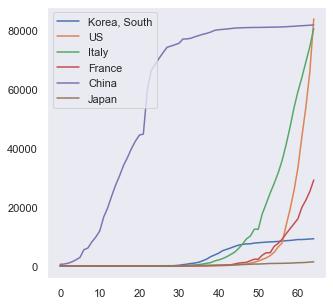

In [99]:
comp.plot()


**Prevention**  
   To avoid the critical situation people are suggested to do following things  
*     Avoid contact with people who are sick. 
*     Avoid touching your eyes, nose, and mouth. 
*     Stay home when you are sick. 
*     Cover your cough or sneeze with a tissue, then throw the tissue in the trash. 
*    Clean and disinfect frequently touched objects and surfaces using a regular household  
*    Wash your hands often with soap and water, especially after going to the bathroom; before eating; and after blowing     your nose, coughing, or sneezing. If soap and water are not readily available, use an alcohol-based hand sanitizer.